In [16]:
import torch
import json
import numpy as np
import torch.nn as nn
import sys
from tqdm import tqdm
import pandas as pd
from models import sam_model_registry, SamPredictor
sys.path.append('../')
from models.unet import ResUnetPlusPlus
import matplotlib.pyplot as plt
import os
import cv2
import gc
from PIL import Image
from torchvision import transforms
from utils import iou_loss, ensure_path, make_logger
from skimage.measure import find_contours
from points_finder import find_centroids_gravity_center_recursive

def load_image_paths(root_path):
    image_paths = []
    image_extensions = ['.jpg', '.png']  # Note the change here to just the extension
    for dirpath, _, filenames in os.walk(root_path):
        for file in filenames:
            if file.endswith(tuple(image_extensions)) and 'label' not in file:
                image_paths.append(os.path.join(dirpath, file))

    return image_paths

def save_image(img, path):
    if img.dtype != np.uint8:
        print("Error: Image dtype should be uint8.")
        return
    if img.min() < 0 or img.max() > 255:
        print("Error: Pixel values should be in [0, 255].")
        return
    if len(img.shape) == 3:
        if img.shape[0] == 3 or img.shape[0] == 4:  
            img = img.transpose(1, 2, 0)

    dir_name = os.path.dirname(path)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    success = cv2.imwrite(path, img_bgr)
    if not success:
        print("Error: Image failed to save.")

def convert_and_swap(input_data):
    if isinstance(input_data, tuple):
        # 如果输入是单个元组
        return [input_data[1], input_data[0]]
    elif isinstance(input_data, list):
        # 如果输入是元组的列表
        return [[item[1], item[0]] for item in input_data]
    elif isinstance(input_data, np.ndarray) and input_data.shape == (2,):
        # 如果输入是一个numpy数组形状为(2,)
        return [input_data[1], input_data[0]]
    else:
        raise TypeError(f"Expected input_data to be a tuple, list, or a numpy array of shape (2,), but got {type(input_data)}")

def extend_point(centroid, point, extension_length):
    # Compute the direction vector from the centroid to the point
    direction = point - centroid
    
    # Normalize the direction vector
    normalized_direction = direction / np.linalg.norm(direction)
    
    # Scale it by the extension length
    extended_vector = normalized_direction * extension_length
    
    # Compute the new extended point
    extended_point = point + extended_vector
    
    return extended_point

def unet_predict(unet, image, gt):
    # predict with unet
    image_tensor = transforms.ToTensor()(image)
    image_tensor = image_tensor.unsqueeze(0).cuda()
    outputs = unet(image_tensor)
    outputs_lowres = nn.MaxPool2d(4)(outputs)
    pre = (outputs>0.5).float().squeeze().cpu().detach().numpy()
    del outputs, unet, image_tensor
    torch.cuda.empty_cache()
    return outputs_lowres, pre

def sam_predict(sam_predictor, image, gt, outputs_lowres, point_coords=None, point_labels=None):
    # predict with sam
    sam_predictor.set_image(image)
    masks, iou_predictions, _ = sam_predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        mask_input=outputs_lowres.squeeze(0).cpu().detach().numpy(),
        multimask_output=True,
    )
    # sort masks according to iou_predictions
    
    pre = masks[0]
    sam_predictor.reset_image()
    del sam_predictor, image, gt, outputs_lowres
    torch.cuda.empty_cache()
    return pre

def find_points(unet_pre, extension_length=20):
    labeled_mask, large_region_labels, large_region_centroids = find_centroids_method(unet_pre)
    points_list = []
    label_list = []
    # find negative points
    padding = 5  # Specify the amount of padding

    for region_label, centroid in zip(large_region_labels, large_region_centroids):
        # Get the mask of the current region
        mask_for_region = labeled_mask == region_label
        
        # Pad the mask
        padded_mask = np.pad(mask_for_region, padding, mode='constant', constant_values=0)
        
        # Find contours on the padded mask
        contours = find_contours(padded_mask, 0.5)
        
        # Get the longest contour and adjust its coordinates due to padding
        longest_contour = sorted(contours, key=lambda x: len(x))[-1]
        longest_contour -= padding
        
        # Find points with the same x-coordinate as the centroid
        horizontal_points = [point for point in longest_contour if np.abs(point[1] - centroid[1]) < 1]
        
        # Find points with the same y-coordinate as the centroid
        vertical_points = [point for point in longest_contour if np.abs(point[0] - centroid[0]) < 2]
        
        # Get the top and bottom points by y-coordinate
        if horizontal_points:
            horizontal_points_sorted = sorted(horizontal_points, key=lambda x: x[0])
            bottom_point = horizontal_points_sorted[0]
            top_point = horizontal_points_sorted[-1]
            bottom_point = extend_point(centroid, horizontal_points_sorted[0], extension_length)
            top_point = extend_point(centroid, horizontal_points_sorted[-1], extension_length)
            bottom_point, top_point = convert_and_swap(bottom_point), convert_and_swap(top_point)
            points_list.extend([top_point, bottom_point])
            label_list.extend([0, 0])
        
        # Get the left and right points by x-coordinate
        if vertical_points:
            vertical_points_sorted = sorted(vertical_points, key=lambda x: x[1])
            left_point = vertical_points_sorted[0]
            right_point = vertical_points_sorted[-1]
            left_point = extend_point(centroid, vertical_points_sorted[0], extension_length)
            right_point = extend_point(centroid, vertical_points_sorted[-1], extension_length)
            left_point, right_point = convert_and_swap(left_point), convert_and_swap(right_point)
            points_list.extend([left_point, right_point])
            label_list.extend([0, 0])

        centroid = convert_and_swap(centroid)
        points_list.append(centroid)
        label_list.append(1)
    # Display the result
    input_point = np.array(points_list) if len(points_list) > 0 else None
    input_label = np.array(label_list) if len(label_list) > 0 else None   
    filltered_point = []
    filltered_label = []
    try:
        for point, label in zip(input_point, input_label):
            if unet_pre[int(point[1]), int(point[0])] == 0 and label == 0 or label == 1:
                # plt.scatter(point[0], point[1], color='green', marker='*', s=50, edgecolor='white', linewidth=1.25)
                filltered_point.append(point)
                filltered_label.append(label)
    except:
        pass
    input_point = np.array(filltered_point) if len(points_list) > 0 else None
    input_label = np.array(filltered_label) if len(label_list) > 0 else None
    return input_point, input_label

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用GPU 0

# find_centroids_methods = [find_centroids_gravity_center_recursive, find_centroids_shrink_mask, find_centroids_gravity_center_adjusted]
find_centroids_method = find_centroids_gravity_center_recursive
# Load model
sam_checkpoint = "./src/sam_pretrained/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.cuda()
predictor = SamPredictor(sam)
# load model
unet = ResUnetPlusPlus(3)
unet = unet.cuda()
unet.load_state_dict(torch.load('./save/Wear_detection/Mechanical damage/dmg/best_model.pth'))
unet.eval();

In [18]:
image_path = 'save/Wear_detection/Mechanical damage_pre/PTF2820_U10473_DP3/Flank/PTF2820 8,2 DP3 slaepsida 30 cyl 4x_ID165016893.jpg'
image = np.array(Image.open(image_path).convert('RGB'))
gt = np.array(Image.open(image_path.replace('.jpg', '_dmg_gt.png')).convert('L'))
# predict with unet
image_resized = cv2.resize(image, (1024,1024), interpolation=cv2.INTER_NEAREST)
gt_resized = cv2.resize(gt, (1024,1024), interpolation=cv2.INTER_NEAREST)
outputs_lowres, unet_pre = unet_predict(unet, image_resized, gt_resized)
unet_pre_bitmap = cv2.resize(unet_pre.astype(np.uint8), (gt.shape[1],gt.shape[0]), interpolation=cv2.INTER_NEAREST)
# predict with sam and centroids and negative points
input_point, input_label = find_points(unet_pre_bitmap)


Text(0.5, 1.0, 'unet_pre')

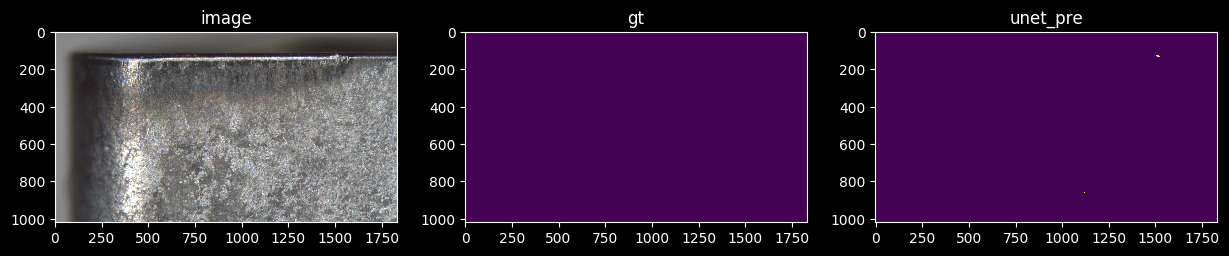

In [19]:
# plot image and gt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title('image')
ax[1].imshow(gt)
ax[1].set_title('gt')
ax[2].imshow(unet_pre_bitmap)
ax[2].set_title('unet_pre')

TypeError: 'NoneType' object is not subscriptable

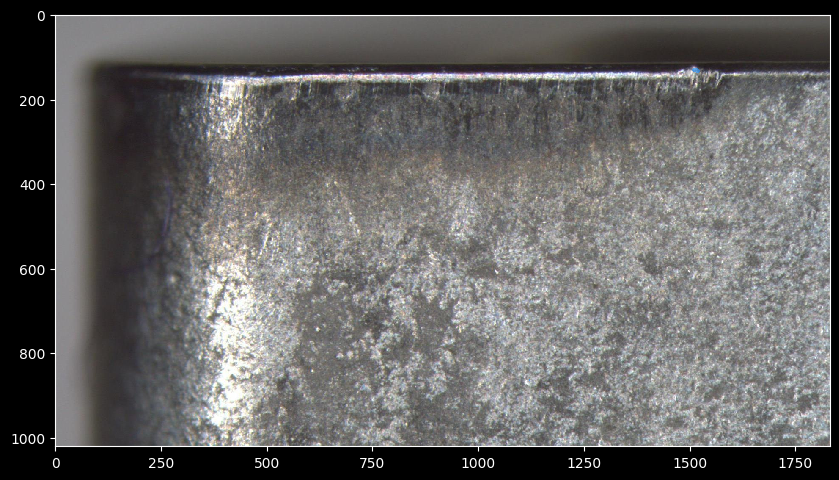

In [20]:
# plot points
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=50):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
   
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(unet_pre_bitmap, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()
print(input_point)


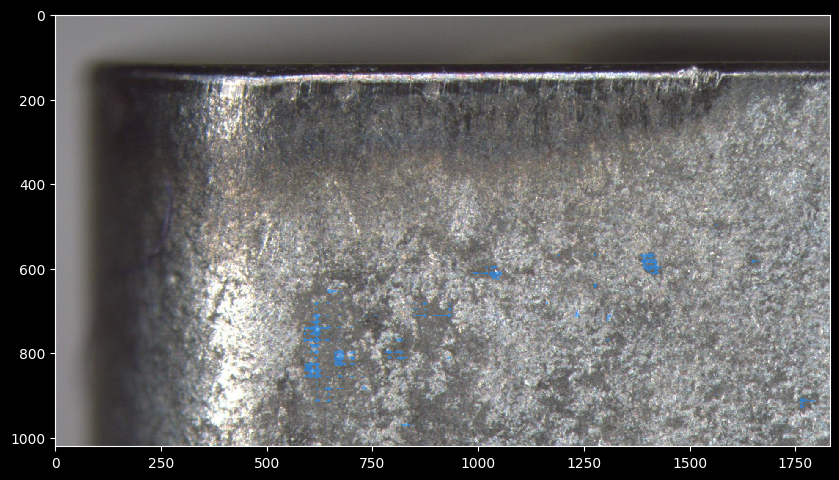

: 

In [21]:

sam_pre = sam_predict(predictor, image, gt, outputs_lowres, input_point, input_label)
sam_pre_bitmap = cv2.resize(sam_pre.astype(np.uint8), (gt.shape[1],gt.shape[0]), interpolation=cv2.INTER_NEAREST)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(sam_pre_bitmap, plt.gca())
